In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.manual_seed(0)

In [6]:
ddir = 'hymenoptera_data'

# Data normalization and augmentation transformations for train dataset
# Only normalization transformation for validation dataset
# The mean and std for normalization are calculated as the mean of all pixel values for all images in the training set per each image channel - R, G and B

data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])]),
    'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])])}

img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']}
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True, num_workers=2) 
            for k in ['train', 'val']}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


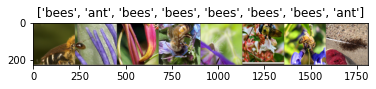

In [7]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

# Generate one train dataset batch
imgs, cls = next(iter(dloaders['train']))

# Generate a grid from batch
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text=[classes[c] for c in cls])

In [ ]:
def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    start = time.time()

    model_weights = copy.deepcopy(pretrained_model.state_dict())
    accuracy = 0.0


    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        
        # for each epoch we run through the training and validation set
        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()  # set model to train mode (i.e. trainbale weights)
            else:
                pretrained_model.eval()   # set model to validation mode

            loss = 0.0
            successes = 0

            # iterate over the (training/validation) data.
            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()
                
                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    # backward pass only if in training mode
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'Best validation set accuracy: {accuracy}')

    # load the best model version (weights)
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model